In [1]:
import torch
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import PILToTensor
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [2]:
try:
    dataset = MNIST(root="/Users/loggiasr/Projects/ReIntAI/tmp", transform=PILToTensor())
except RuntimeError:
    dataset = MNIST(root="/Users/loggiasr/Projects/ReIntAI/tmp", download=True, transform=PILToTensor())

torch.Size([9, 9])


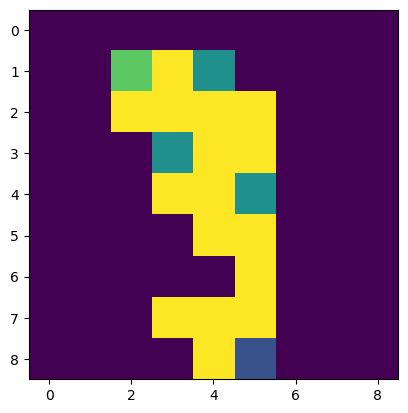

torch.Size([9, 9])


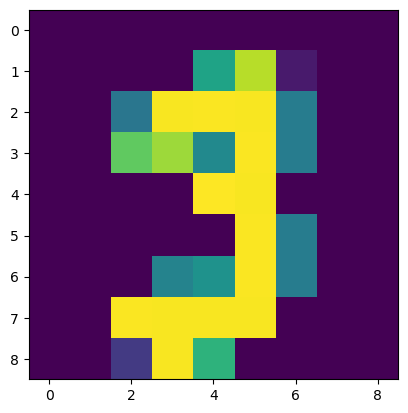

torch.Size([9, 9])


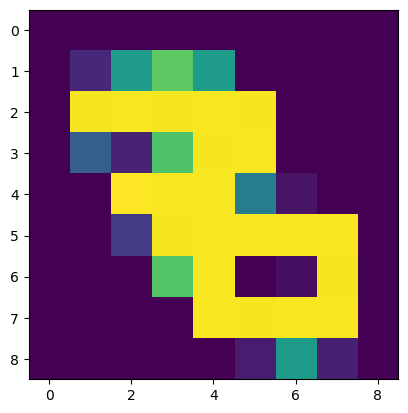

torch.Size([9, 9])


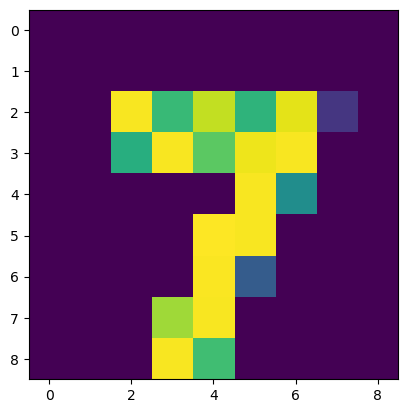

torch.Size([9, 9])


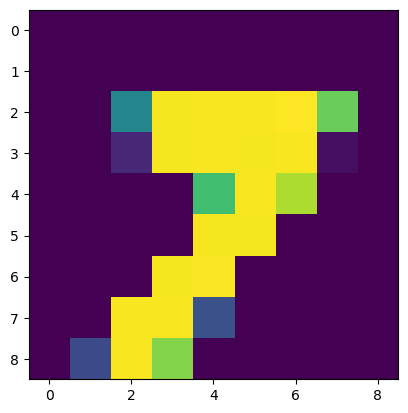

In [3]:
pool = torch.nn.MaxPool2d(3)
data_load = DataLoader(dataset, shuffle=True, batch_size=1)
for i, (batch, labels) in enumerate(data_load):
    if i < 20:
        continue
    if i > 40:
        break
    if labels in [3, 7]:
        batch = torch.from_numpy(np.array(batch)).float()
        batch = pool(batch.reshape((1, 1, batch.shape[-1], -1))).squeeze()
        batch = (batch - batch.mean()) / batch.std()
        plt.imshow(batch)
        print(batch.shape)
        plt.pause(.05)

In [4]:
# loss function that just wants each step better than the discounted average of the last few. 
def l2l_loss(logits, targets, lfxn, classes=3, power=2, window=3):
    """
    :param logits: (examples, classes)
    :param targets: (examples)
    :param classes: num classes
    :param power: higher powers encourage larger step changes
    :return: 
    """
    targets = torch.Tensor(targets).long()
    conv_1d = torch.nn.Conv1d(in_channels=1, out_channels=1, kernel_size=window, padding=1, padding_mode="replicate")
    conv_1d.weight = torch.nn.Parameter(torch.ones_like(conv_1d.weight) / window)
    conv_1d.bias = torch.nn.Parameter(torch.zeros_like(conv_1d.bias))
    ce_loss = lfxn(logits, targets).view((-1,)) #
    print(ce_loss)
    filt_ce_loss = conv_1d(ce_loss.view((1, 1, -1))).flatten()
    ce_loss = filt_ce_loss[1:] - filt_ce_loss[:-1].detach()
    ce_loss = ce_loss + torch.relu(ce_loss) * 4
    print(ce_loss)
    loss = torch.sum(ce_loss) #+ torch.pow(chance_ce - ce_loss[0], 2)
    print(loss)
    return loss
    
    

In [23]:
from intrinsic.model import Intrinsic
class Decoder:
    
    def __init__(self):
        self.model = Intrinsic(num_nodes=5, node_shape=(1, 3, 9, 9), kernel_size=6, input_mode="overwrite")
        self.train_labels = [3, 7]
        self.decoder = torch.nn.Linear(in_features=9**2, out_features=len(self.train_labels))
        self.optim = torch.optim.Adam(params=[self.model.resistance,
                                              self.model.edge.init_weight,
                                              self.model.edge.plasticity,
                                              self.model.edge.chan_map] + list(self.decoder.parameters()), lr=1e-5)

        self.history = []
        
    def forward(self, X, y):
        pool = torch.nn.MaxPool2d(3)
        img = X.float()
        img = pool(img.reshape((1, 1, img.shape[-1], -1))).squeeze()
        img = (img - img.mean()) / img.std()
        in_states = torch.zeros_like(self.model.states)
        mask = in_states.bool()
        for i in range(4):
            with torch.no_grad():
                in_states[0, 0, :, :] = img.detach()
                mask[0, 0, :, :] = True
            self.model(in_states.detach(), mask.detach())
        in_features = self.model.states[2, 0, :, :]
        logits = self.decoder(in_features.view(1, 1, -1)).flatten()
        correct = (torch.argmax(logits) == y).float() * .2 - .1
        for i in range(2):
            # in_states = torch.zeros_like(self.model.states)
            # mask = in_states.bool()
            in_states[1, 0, :, :] = correct
            mask[1, 0, :, :] = True
            self.model(in_states, mask.detach())
        for i in range(1):
            self.model()
        return logits
    
    def _fit(self, data, label_map, iter=100):
        all_logits = []
        all_labels = []
        count = 0
        for img, label in data:
            if label not in label_map:
                continue
            if count > iter:
                break
            label = label_map.index(label)
            logits = self.forward(img, label)
            all_logits.append(logits.clone())
            all_labels.append(label)
            count += 1
        return torch.stack(all_logits, dim=0), torch.Tensor(all_labels).long()
        
            
    def l2l_fit(self, data, epochs=1000, batch_size=100):
        l_fxn = torch.nn.CrossEntropyLoss(reduce=False)
        data = DataLoader(data, shuffle=True, batch_size=1)
        for epoch in range(epochs):
            self.optim.zero_grad()
            if (epoch % 10) == 0:
                self.model.detach(reset_intrinsic=True)
            else:
                self.model.detach(reset_intrinsic=False)
            logits, labels = self._fit(data, self.train_labels, batch_size)
            # loss = torch.sum(logits)
            loss = l2l_loss(logits, labels, l_fxn) # + .33 * torch.mean(l_fxn(logits, labels)) # 
            reg = torch.sum(torch.abs(self.model.edge.chan_map))
            self.history.append(loss.detach().cpu().item())
            print("Epoch", epoch, "loss is", self.history[-1])
            loss = loss + .001 * reg
            print('REG', .001 * reg)
            #init_plast = self.model.edge.chan_map.clone()
            loss.backward()
            self.optim.step()
            #print("change:", init_plast - self.model.edge.chan_map.clone())

            
    def forward_fit(self, data, iter, use_labels=None):
        self.model.detach(reset_intrinsic=True)
        if use_labels is None:
            use_labels = self.train_labels
        l_fxn = torch.nn.CrossEntropyLoss()
        data = DataLoader(data, shuffle=True, batch_size=1)
        with torch.no_grad():
            logits, labels = self._fit(data, use_labels, iter)
            # loss = l2l_loss(logits, labels, l_fxn)
        #print("Self Learn Loss:", loss.detach().item())
        
    def evaluate(self, data, iter, use_labels=None):
        if use_labels is None:
            use_labels = self.train_labels
        l_fxn = torch.nn.CrossEntropyLoss()
        data = DataLoader(data, shuffle=True, batch_size=1)
        with torch.no_grad():
            logits, labels = self._fit(data, use_labels, iter)
        labels = torch.Tensor(labels).long()
        avg_loss = l_fxn(logits, labels)
        preds = torch.argmax(logits, dim=1)
        acc = torch.count_nonzero(preds == labels) / len(labels)
        print(iter, "Iterations, avg CE:", avg_loss.detach().item(), "acc:", acc.detach().item())
        
                

In [26]:
with open("/Users/loggiasr/Projects/ReIntAI/models/mnist_models/new_pool3_l2l.pkl", "rb") as f:
    decoder = pickle.load(f)
decoder.optim = torch.optim.Adam(params=[decoder.model.resistance,
                                              decoder.model.edge.init_weight,
                                              decoder.model.edge.plasticity,
                                              decoder.model.edge.chan_map] + list(decoder.decoder.parameters()), lr=1e-4)

In [27]:
# decoder.forward = Decoder().forward
# decoder = Decoder()
decoder.l2l_fit(dataset, 1000, 10)

tensor([0.9666, 0.8284, 0.6234, 0.6475, 0.7209, 0.7180, 0.7083, 0.6770, 0.7216,
        0.7948, 0.7612], grad_fn=<ViewBackward0>)
tensor([-0.1144, -0.1064, -0.0358,  0.1578,  0.1013, -0.0147,  0.0060,  0.1442,
         0.1404,  0.0660], grad_fn=<AddBackward0>)
tensor(0.3444, grad_fn=<SumBackward0>)
Epoch 0 loss is 0.3444116711616516
REG tensor(0.0249, grad_fn=<MulBackward0>)
tensor([0.6178, 0.5579, 0.7987, 0.5422, 0.8371, 0.6420, 0.5706, 0.8672, 0.7835,
        0.6091, 0.5731], grad_fn=<ViewBackward0>)
tensor([ 0.3015, -0.0252,  0.4654, -0.0522,  0.0474,  0.0501,  0.2359,  0.0641,
        -0.0980, -0.0701], grad_fn=<AddBackward0>)
tensor(0.9188, grad_fn=<SumBackward0>)
Epoch 1 loss is 0.9187983870506287
REG tensor(0.0249, grad_fn=<MulBackward0>)
tensor([0.9004, 0.5136, 0.8548, 0.8666, 0.8440, 0.8497, 0.5567, 0.8397, 0.5245,
        0.9025, 0.5330], grad_fn=<ViewBackward0>)
tensor([-0.0152, -0.0113,  0.5506, -0.0017, -0.1033, -0.0014, -0.1084,  0.5764,
        -0.1022,  0.0142], grad_fn

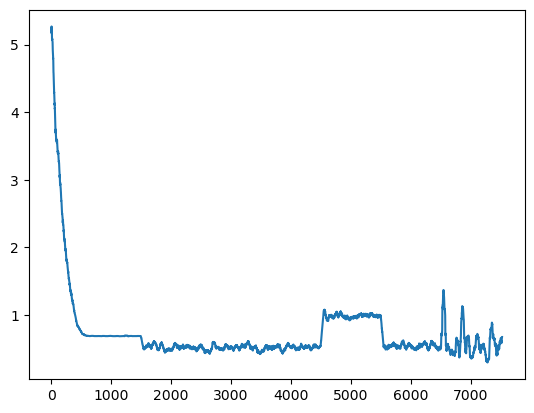

In [28]:
from scipy.ndimage import uniform_filter1d
plt.plot(uniform_filter1d(decoder.history, size=50))
plt.show()

In [72]:
import pickle
with open("/Users/loggiasr/Projects/ReIntAI/models/mnist_models/new_pool3_l2l.pkl", "wb") as f:
    pickle.dump(decoder, f)

In [11]:
# Evaluate preformance on train labels (3, 7)
decoder.forward_fit(dataset, 2000)

In [12]:
decoder.evaluate(dataset, 1000)

1000 Iterations, avg CE: 0.6906278133392334 acc: 0.5354645252227783


In [29]:
# Evaluate preformance on test held out labels (2, 6)
decoder.forward_fit(dataset, 200, use_labels=[7, 3])

In [30]:
#decoder.model.edge.plasticity = torch.nn.Parameter(torch.zeros_like(decoder.model.edge.plasticity))
decoder.evaluate(dataset, 200, use_labels=[7, 3])

200 Iterations, avg CE: 0.7091808319091797 acc: 0.5074626803398132
